In [0]:
from fastai import *
from fastai.tabular import *
import pandas as pd
from torchsummary import summary
import torch
from torch import nn
import imageio
import torch
import glob
from fastai.vision import *
import os
from torch import nn
import torch.nn.functional as F

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
%cd "/content/drive/My Drive/automatic-asset-classification"
%ls "/content/drive/My Drive/automatic-asset-classification"
image_path = "/content/drive/My Drive/automatic-asset-classification/data/final_dataset"

data = ImageDataBunch.from_folder(image_path, valid_pct = 0.2, size=224,ds_tfms=get_transforms(), 
                                  test = "test").normalize(imagenet_stats)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/automatic-asset-classification
ae_res_1_new    ae_res_3_new    ae_res_4_torch  ae_res_6_torch
ae_res_1_torch  ae_res_3_torch  ae_res_5_new    data/
ae_res_2_new    ae_res_4_new    ae_res_5_torch  final_model
ae_res_2_torch  ae_res_4-new    ae_res_6_new    models/


In [0]:
class ConvBlock(nn.Module):
    def __init__(self, ni, no, ks, stride, bn=True, pad=None):
        super().__init__()
        if pad is None: pad = ks//2//stride
        self.conv = nn.Conv2d(ni, no, ks, stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(no) if bn else None
        self.relu = nn.LeakyReLU(0.2, inplace=True)
    
    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.bn(x) if self.bn else x

In [0]:
class DCGAN_D(nn.Module):
    def __init__(self, isize, nc, ndf, n_extra_layers=0):
        super().__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        self.initial = ConvBlock(nc, ndf, 4, 2, bn=False)
        csize,cndf = isize/2,ndf
        self.extra = nn.Sequential(*[ConvBlock(cndf, cndf, 3, 1)
                                    for t in range(n_extra_layers)])

        pyr_layers = []
        while csize > 4:
            pyr_layers.append(ConvBlock(cndf, cndf*2, 4, 2))
            cndf *= 2; csize /= 2
        self.pyramid = nn.Sequential(*pyr_layers)
        
        self.final = nn.Conv2d(cndf, 1, 4, padding=0, bias=False)

    def forward(self, input):
        x = self.initial(input)
        x = self.extra(x)
        x = self.pyramid(x)
        return self.final(x).mean(0).view(1)

In [0]:
class DeconvBlock(nn.Module):
    def __init__(self, ni, no, ks, stride, pad, bn=True):
        super().__init__()
        self.conv = nn.ConvTranspose2d(ni, no, ks, stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(no)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.bn(x) if self.bn else x

In [0]:
class DCGAN_G(nn.Module):
    def __init__(self, isize, nz, nc, ngf, n_extra_layers=0):
        super().__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        cngf, tisize = ngf//2, 4
        while tisize!=isize: cngf*=2; tisize*=2
        layers = [DeconvBlock(nz, cngf, 4, 1, 0)]

        csize, cndf = 4, cngf
        while csize < isize//2:
            layers.append(DeconvBlock(cngf, cngf//2, 4, 2, 1))
            cngf //= 2; csize *= 2

        layers += [DeconvBlock(cngf, cngf, 3, 1, 1) for t in range(n_extra_layers)]
        layers.append(nn.ConvTranspose2d(cngf, nc, 4, 2, 1, bias=False))
        self.features = nn.Sequential(*layers)

    def forward(self, input): return F.tanh(self.features(input))

In [0]:
bs,sz,nz = 64,64,100

In [0]:
netG = DCGAN_G(sz, nz, 3, 64, 1).cuda()
netD = DCGAN_D(sz, 3, 64, 1).cuda()

In [0]:
from distutils.version import LooseVersion
USE_GPU = torch.cuda.is_available()
IS_TORCH_04 = LooseVersion(torch.__version__) >= LooseVersion('0.4')
def to_gpu(x, *args, **kwargs):
    '''puts pytorch variable to gpu, if cuda is available and USE_GPU is set to true. '''
    return x.cuda(*args, **kwargs) if USE_GPU else x

def T(a, half=False, cuda=True):
    """
    Convert numpy array into a pytorch tensor. 
    if Cuda is available and USE_GPU=True, store resulting tensor in GPU.
    """
    if not torch.is_tensor(a):
        a = np.array(np.ascontiguousarray(a))
        if a.dtype in (np.int8, np.int16, np.int32, np.int64):
            a = torch.LongTensor(a.astype(np.int64))
        elif a.dtype in (np.float32, np.float64):
            a = to_half(a) if half else torch.FloatTensor(a)
        else: raise NotImplementedError(a.dtype)
    if cuda: a = to_gpu(a)
    return a

def map_over(x, f): return [f(o) for o in x] if is_listy(x) else f(x)
def is_listy(x): return isinstance(x, (list,tuple))
def create_variable(x, volatile, requires_grad=False):
    if type (x) != torch.autograd.Variable:
        if IS_TORCH_04: x = torch.autograd.Variable(T(x), requires_grad=requires_grad)
        else:           x = torch.autograd.Variable(T(x), requires_grad=requires_grad, volatile=volatile)
    return x

def V(x, requires_grad=False, volatile=False):
    '''creates a single or a list of pytorch tensors, depending on input x. '''
    return map_over(x, lambda o: V_(o, requires_grad, volatile))

def V_(x, requires_grad=False, volatile=False):
    '''equivalent to create_variable, which creates a pytorch tensor'''
    return create_variable(x, volatile=volatile, requires_grad=requires_grad)


In [0]:
def create_noise(b): return V(torch.zeros(b, nz, 1, 1).normal_(0, 1))

In [0]:
pred_ims = data.one_batch()

In [36]:
nn.functional.tanh = torch.tanh

preds = netG(create_noise(4))
pred_ims = data.trn_ds.denorm(preds)

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for i,ax in enumerate(axes.flat): ax.imshow(pred_ims[i])

AttributeError: ignored

In [0]:
netG = DCGAN_G(sz, nz, 3, 64, 1).cuda()
netD = DCGAN_D(sz, 3, 64, 1).cuda()

In [41]:
nn.Sequential(*children(netD)[:-1])

Sequential(
  (0): ConvBlock(
    (conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (relu): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (1): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (2): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): ConvBlock(
      (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_s

In [0]:
dec = nn.Sequential(*children(netD)[:-1]+[nn.Conv2d(512,100,4,bias=False)]).cuda()

In [43]:
dec

Sequential(
  (0): ConvBlock(
    (conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (relu): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (1): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (2): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): ConvBlock(
      (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_s

In [0]:
autoenc = (nn.Sequential(dec,netG)).cuda()

In [45]:
autoenc

Sequential(
  (0): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (relu): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): ConvBlock(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (2): Sequential(
      (0): ConvBlock(
        (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (1): ConvBlock(
        (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, t

In [46]:
data

ImageDataBunch;

Train: LabelList (387 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
embankment,embankment,embankment,embankment,embankment
Path: /content/drive/My Drive/automatic-asset-classification/data/final_dataset;

Valid: LabelList (96 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
flood_gate,flood_wall,flood_wall,flood_gate,embankment
Path: /content/drive/My Drive/automatic-asset-classification/data/final_dataset;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: /content/drive/My Drive/automatic-asset-classification/data/final_dataset

In [0]:
np.random.seed(3333)
torch.manual_seed(3333)
image_path = "/content/drive/My Drive/automatic-asset-classification/data/final_dataset"
size = 64
batchsize = 32

tfms = get_transforms(do_flip = True)
src = (ImageImageList.from_folder(image_path).split_by_rand_pct().label_from_func(lambda x: x))
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=batchsize)
        .normalize(imagenet_stats, do_y = False))

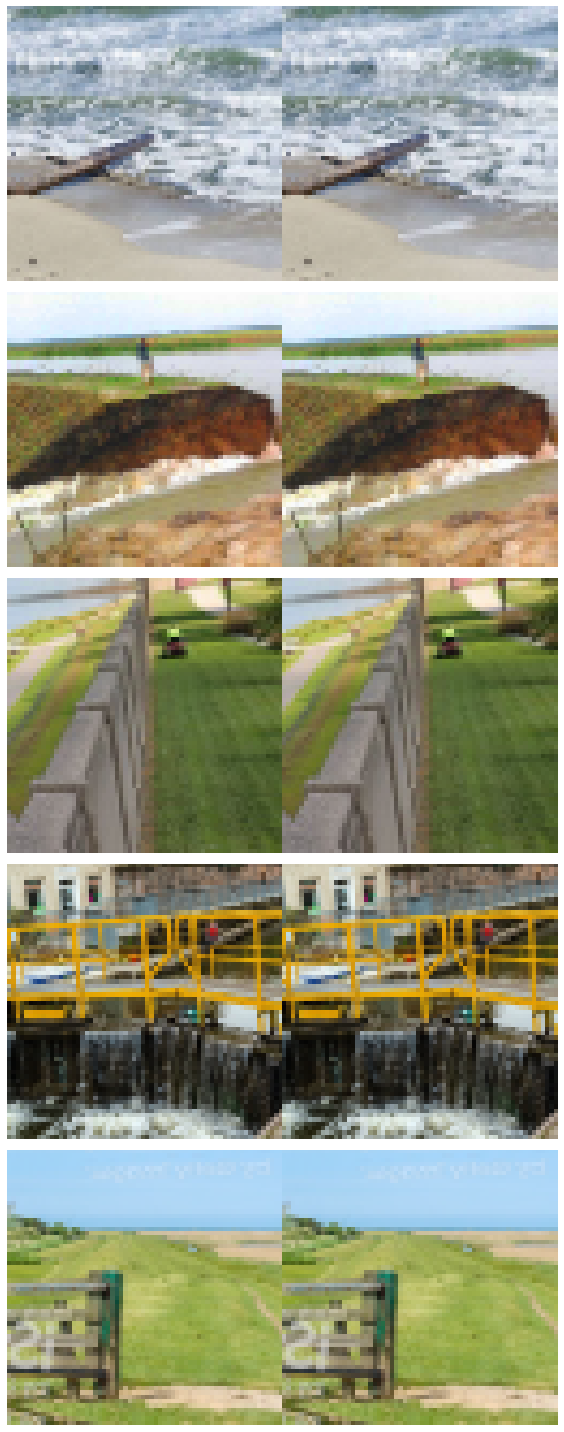

In [51]:
data.show_batch()

In [0]:
learn = Learner(data, autoenc, loss_func =  F.mse_loss)

In [53]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,time
0,0.324430,1.147653,01:10


In [54]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,0.178376,#na#,00:12
1,0.182391,#na#,00:12
2,0.179591,#na#,00:12
3,0.172591,#na#,00:12
4,0.161927,#na#,00:12
5,0.145445,#na#,00:12
6,0.164988,#na#,00:12
7,0.209617,#na#,00:12


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 8.32E-06
Min loss divided by 10: 1.00E-02


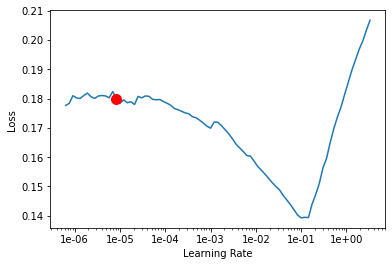

In [55]:
learn.recorder.plot(suggestion = True)

In [56]:
learn.fit_one_cycle(20, max_lr=1e-02)

epoch,train_loss,valid_loss,time
0,0.166524,0.373218,00:16
1,0.143569,0.292299,00:15
2,0.123641,0.178045,00:15
3,0.106876,0.222915,00:16
4,0.093965,0.095606,00:15
5,0.082124,0.048276,00:15
6,0.071990,0.042797,00:15
7,0.064509,0.061436,00:16
8,0.058550,0.034580,00:16
9,0.053185,0.033067,00:16


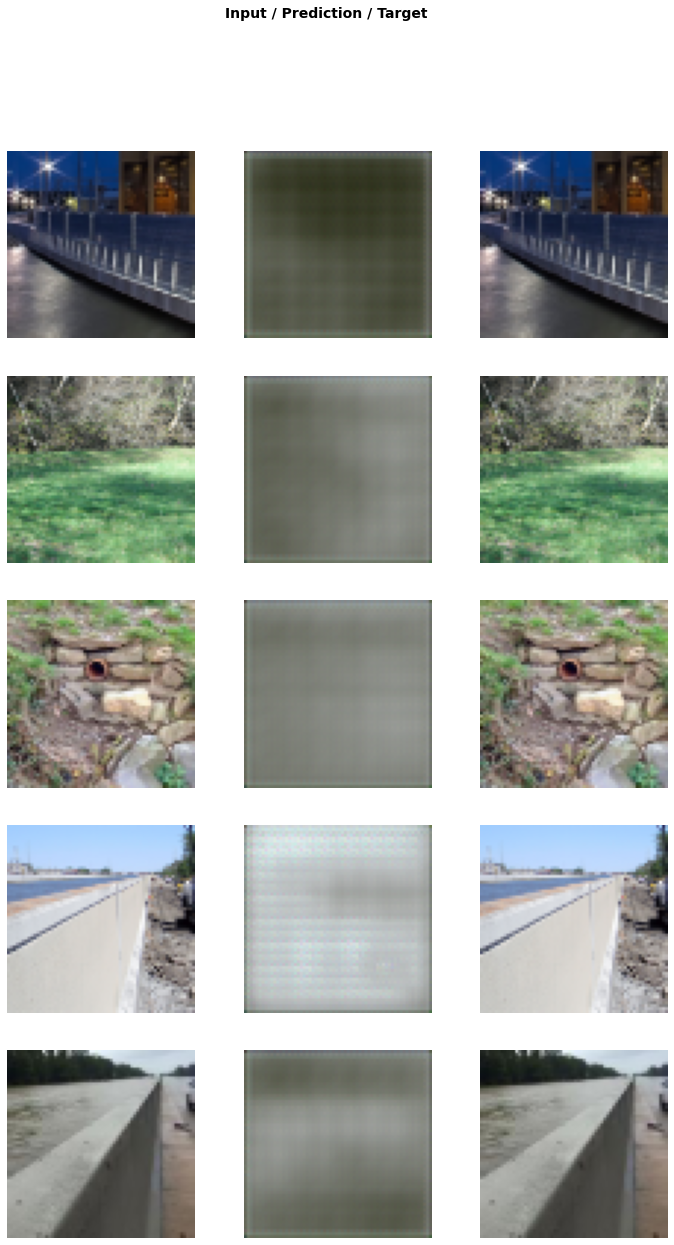

In [57]:
learn.show_results()

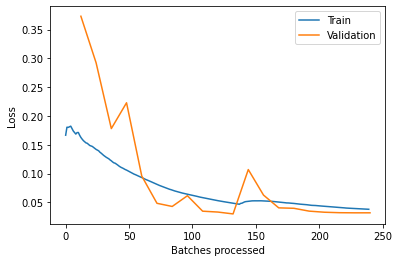

In [58]:
learn.recorder.plot_losses()

In [59]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,0.033144,#na#,00:13
1,0.033154,#na#,00:11
2,0.033164,#na#,00:12
3,0.032758,#na#,00:12
4,0.032804,#na#,00:12
5,0.032863,#na#,00:12
6,0.046771,#na#,00:12


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.29E-06
Min loss divided by 10: 1.32E-03


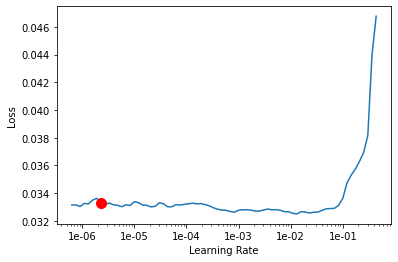

In [60]:
learn.recorder.plot(suggestion = True)

In [61]:
learn.fit_one_cycle(20, max_lr=1e-02)

epoch,train_loss,valid_loss,time
0,0.032344,0.031441,00:15
1,0.032780,0.031859,00:16
2,0.032338,0.031029,00:15
3,0.031708,0.030274,00:15
4,0.031404,0.029498,00:16
5,0.031126,0.034210,00:16
6,0.031121,0.030529,00:15
7,0.031033,0.028832,00:16
8,0.030079,0.025963,00:15
9,0.030903,0.057386,00:15


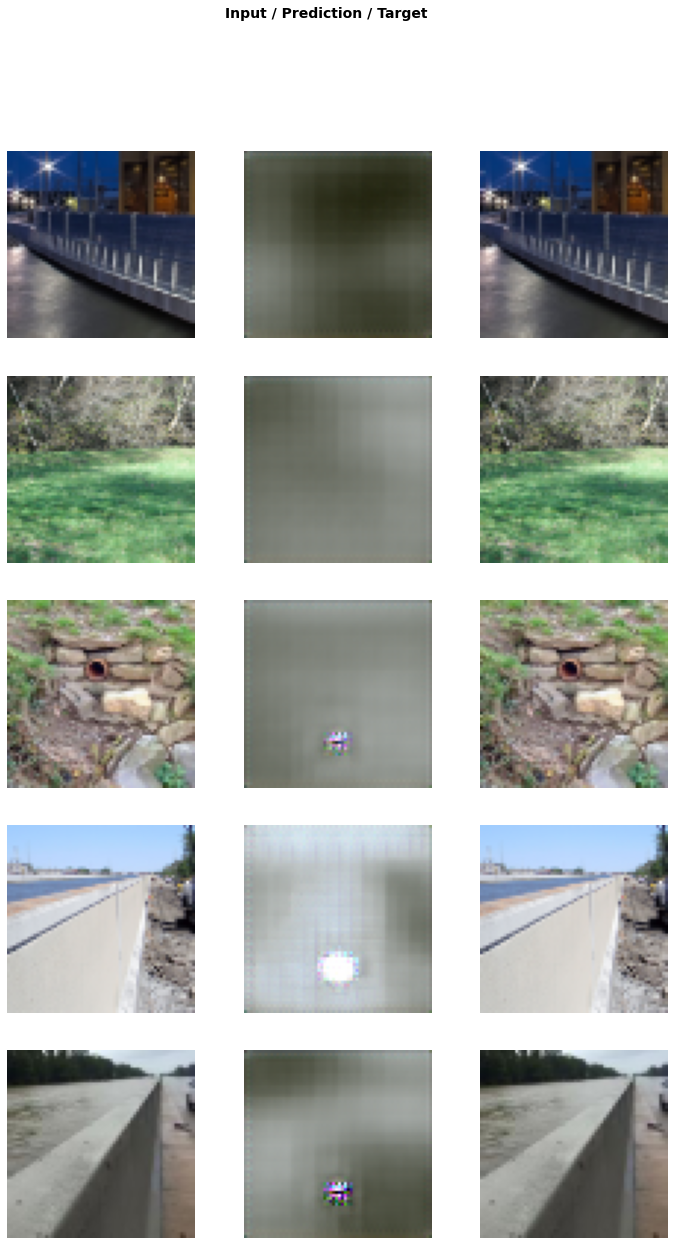

In [62]:
learn.show_results()

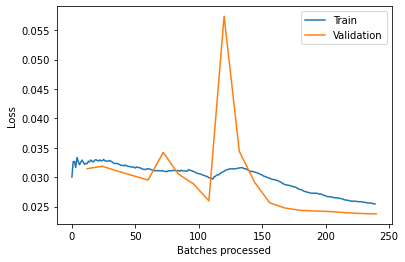

In [63]:
learn.recorder.plot_losses()

In [64]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,0.024308,#na#,00:12
1,0.023856,#na#,00:11
2,0.024082,#na#,00:12
3,0.024429,#na#,00:11
4,0.024429,#na#,00:12
5,0.025056,#na#,00:11


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 9.12E-07
Min loss divided by 10: 4.79E-07


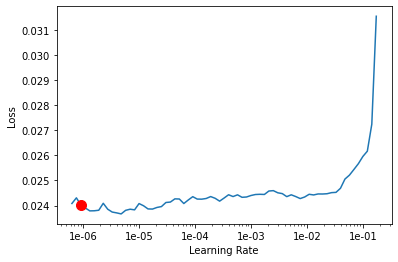

In [65]:
learn.recorder.plot(suggestion = True)

In [66]:
learn.fit_one_cycle(20, max_lr=1e-05)

epoch,train_loss,valid_loss,time
0,0.024248,0.023773,00:15
1,0.024316,0.023798,00:15
2,0.024187,0.023806,00:16
3,0.024166,0.023728,00:16
4,0.024139,0.023723,00:15
5,0.024164,0.023693,00:15
6,0.024035,0.023742,00:15
7,0.023976,0.023692,00:16
8,0.024128,0.023689,00:15
9,0.024145,0.023686,00:16


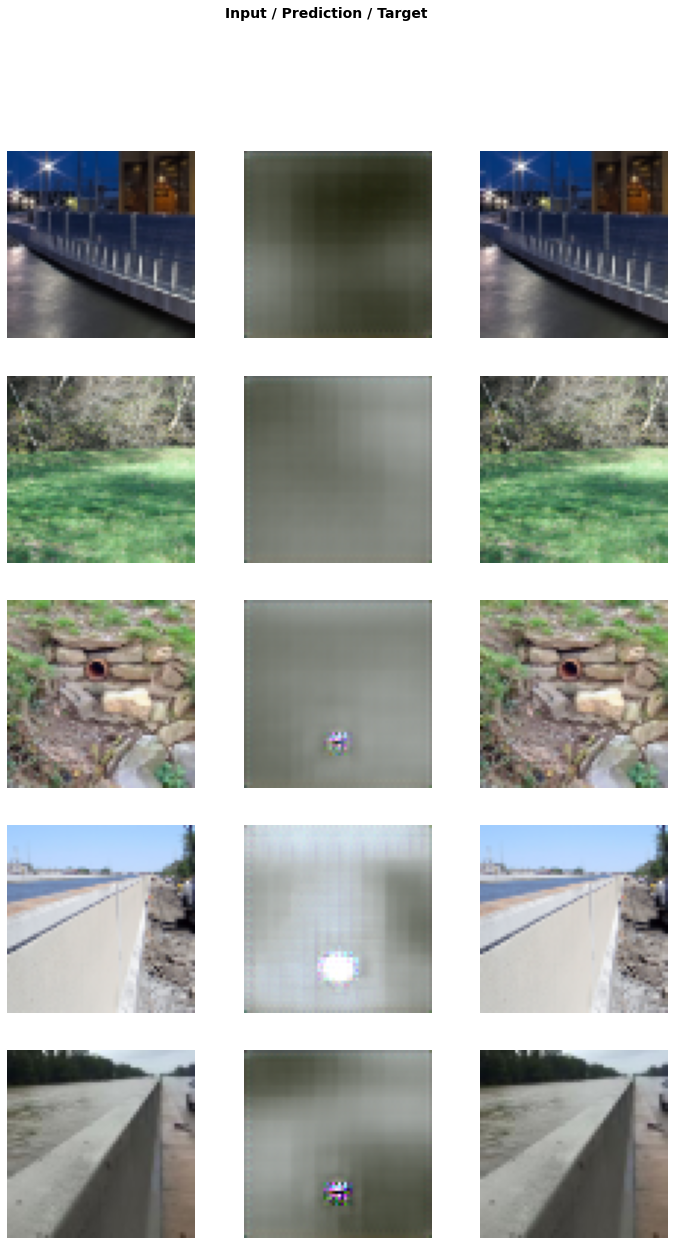

In [67]:
learn.show_results()

learning has plataued however maybe simpler architectures are better? or atleast are easier to train.